In [1]:
# Imports
import os
import json
import uuid
import pandas as pd
import plotly.express as px
from datetime import datetime, timedelta
from typing import List, TypedDict
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START,END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display, Markdown, HTML
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing import Optional, List, Union



load_dotenv()

os.environ["groq_api_key"] =  os.getenv('groq_api_key')

# note only few selected models are only compatible with with_structured_output() method
# and we are using groq model here which is compatible
llm = ChatGroq(
    groq_api_key=os.getenv('groq_api_key'), model_name="Gemma2-9b-It")


d:\Coding\Python\GenAI Projects\RAG Chatbot\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# llm.invoke("check: working? Not working")

### Key Classes
**State Management**
1. AgentState 
    - project description
    - team
    - tasks
    - dependencies
    - schedule
    - task_allocations
    - risks 
    - iteration_number
    - max_iteration
    - insights
    - schedule_iteration
    - task_allocations_iteration
    - risks_iteration
    - project_risk_score_iterations

2. Task
    - id
    - task_name
    - taks_description
    - estimated_day
3. TaskDependency
4. Team Member
5. Team
6. TaskAllocation
7. TaskSchedule
8. TaskList
9. DependencyList
10. Schedule
11. TaskAllocationList
12. Risk
13. RiskList


- data classes
- agent state
- nodes and functions (used as a router)
- workflow of the agent

In [3]:
# Data Models
class Task(BaseModel):
    """Task model for project management"""
    id: uuid.UUID = Field(default_factory=uuid.uuid4, description="Unique identifier for the task")
    task_name: str = Field(description="Name of the task")
    description: str = Field(description="Description of the task")
    estimated_day: int = Field(description="Estimated number of days to complete the task")


class TaskList(BaseModel):
    """List of project tasks"""
    tasks: List[Task] = Field(description="List of tasks")

class TaskDependency(BaseModel):
    """Task dependency model"""
    task: Task = Field(description="Task")
    dependent_task:List[Task] = Field(description="List of dependent tasks")

class TeamMember(BaseModel):
    name: str = Field(description="Name of the team member")
    profile: str = Field(description="Profile of the team member")

class Team(BaseModel):
    team_members: List[TeamMember] = Field(description="List of team members")

class TaskAllocation(BaseModel):
    """Task allocation class"""
    task: Task = Field(description="Task")
    team_member: TeamMember = Field(description="Team members assigned to the task")

class TaskSchedule(BaseModel):
    """Schedule schedule class"""
    task: Task = Field(description="Task")
    start_day: int = Field(description="Start day of the task")
    end_day: int = Field(description="End day of the task")

class DependencyList(BaseModel):
    """List of task dependencies"""
    dependencies: List[TaskDependency] = Field(description="List of task dependencies")

class Schedule(BaseModel):
    """List of task schedules"""
    schedule: List[TaskSchedule] = Field(description="List of task schedules")

class TaskAllocationList(BaseModel):
    """List of task allocations"""
    task_allocations: List[TaskAllocation] = Field(description="List of task allocations")

class TaskAllocationListIteration(BaseModel):
    """List of task allocations for each iteration"""
    task_allocations_iteration: List[TaskAllocationList] = Field(description="List of task allocations for each iteration")

class ScheduleIteration(BaseModel):
    """List of task schedules for each iteration"""
    schedule: List[Schedule] = Field(description="List of task schedules for each iteration")

class Risk(BaseModel):
    """Risk of a task"""
    task: Task = Field(description="Task")
    score: str = Field(description="Risk associated with the task")

class RiskList(BaseModel):
    """List of risks for each iteration"""
    risks: List[Risk] = Field(description="List of risks")

class RiskListIteration(BaseModel):
    """List of risks for each iteration"""
    risks_iteration: List[RiskList] = Field(description="List of risks for each iteration")



AgentState creation. 
- schedule_iteration, task_allocations_iteration, risks_iteration to generate structured memory for the self_reflection cycles

In [4]:
class AgentState(TypedDict):
    """Project Manager Agent State"""
    project_description: str
    team: Team
    tasks: TaskList
    dependencies: DependencyList
    schedule: Schedule
    task_allocations: TaskAllocationList
    risks: RiskList
    iteration_number: int
    max_iteration: int
    insights: List[str]
    schedule_iteration: List[ScheduleIteration]
    task_allocations_iteration: List[TaskAllocationListIteration]
    risks_iteration: List[RiskListIteration]
    project_risk_score_iterations: List[int]


In [5]:
def task_generation_node(state: AgentState):
    """LangGraph node that will extract tasks from given project description"""
    description = state["project_description"]
    prompt = f"""You are an expert project manager tasked with analyzing the following project description: {description}
    
    Your task is to break this project into clear, actionable tasks. For each task, provide:
    - A clear, concise name
    - A detailed description
    - Estimated days to complete (as a number)

    Please format your response as a JSON object with the following structure:
    {{
        "tasks": [
            {{
                "task_name": "string",
                "description": "string",
                "estimated_day": number
            }}
        ]
    }}

    Guidelines:
    - Each task should be specific and measurable
    - Break down tasks that would take more than 5 days into smaller sub-tasks
    - Estimated days should be realistic integers
    - Task names should be brief but descriptive
    - Descriptions should provide enough detail for implementation
    """
    
    try:
        structure_llm = llm.with_structured_output(TaskList)
        tasks: TaskList = structure_llm.invoke(prompt)
        return {"tasks": tasks}
    except Exception as e:
        print(f"Error in task generation: {str(e)}")
        print(f"Raw response from LLM: {tasks if 'tasks' in locals() else 'No response'}")
        return {"tasks": TaskList(tasks=[])}
def task_dependency_node(state: AgentState):
    """LangGraph node that will identify task dependencies"""
    tasks = state["tasks"]
    prompt = f"""You are a skilled project scheduler analyzing dependencies between tasks.
    
    Given these tasks: {tasks}

    Create a dependency map showing which tasks must be completed before others can begin.
    Format your response as a JSON object with this structure:
    {{
        "dependencies": [
            {{
                "task": {{
                    "task_name": "string",
                    "description": "string",
                    "estimated_day": number,
                    "id": "uuid-string"
                }},
                "dependent_tasks": [
                    {{
                        "task_name": "string",
                        "description": "string",
                        "estimated_day": number,
                        "id": "uuid-string"
                    }}
                ]
            }}
        ]
    }}

    Guidelines:
    - Identify direct dependencies only
    - Ensure no circular dependencies
    - Consider logical sequence of work
    - Include all task details in both task and dependent_tasks objects
    """
    
    try:
        structure_llm = llm.with_structured_output(DependencyList)
        dependencies: DependencyList = structure_llm.invoke(prompt)
        return {"dependencies": dependencies}
    except Exception as e:
        print(f"Error in dependency mapping: {str(e)}")
        print(f"Raw response from LLM: {dependencies if 'dependencies' in locals() else 'No response'}")
        return {"dependencies": DependencyList(dependencies=[])}
def task_scheduler_node(state: AgentState):
    """LangGraph node that will schedule tasks based on dependencies"""
    dependencies = state["dependencies"]
    tasks = state["tasks"]
    insights = state.get('insights', '')
    previous_schedules = state.get("schedule_iteration", [])
    
    prompt = f"""You are an experienced project scheduler creating an optimized timeline.
    
    Given:
    - Tasks: {tasks}
    - Dependencies: {dependencies}
    - Previous Insights: {insights}
    - Previous Schedules: {previous_schedules}

    Create a schedule that assigns start and end days to each task.
    Format your response as a JSON object with this structure:
    {{
        "schedule": [
            {{
                "task": {{
                    "task_name": "string",
                    "description": "string",
                    "estimated_day": number,
                    "id": "uuid-string"
                }},
                "start_day": number,
                "end_day": number
            }}
        ]
    }}

    Guidelines:
    - Respect all task dependencies
    - Minimize total project duration
    - Allow parallel execution where possible
    - Ensure end_day - start_day + 1 equals estimated_day
    - Start with day 1 (no zero days)
    - Include complete task details in each task object
    """
    
    try:
        structure_llm = llm.with_structured_output(Schedule)
        schedule: Schedule = structure_llm.invoke(prompt)
        state["schedule"] = schedule
        state["schedule_iteration"].append(schedule)
        return state
    except Exception as e:
        print(f"Error in scheduling: {str(e)}")
        print(f"Raw response from LLM: {schedule if 'schedule' in locals() else 'No response'}")
        default_schedule = Schedule(schedule=[])
        state["schedule"] = default_schedule
        state["schedule_iteration"].append(default_schedule)
        return state
def task_allocation_node(state: AgentState):
    """LangGraph node that will allocate tasks to team members"""
    tasks = state["tasks"]
    schedule = state["schedule"]
    team = state["team"]
    insights = state.get('insights', '')
    previous_allocations = state.get("task_allocations_iteration", [])
    
    prompt = f"""You are a project manager assigning tasks to team members optimally.
    
    Given:
    - Tasks and Schedule: {schedule}
    - Team Members: {team}
    - Previous Insights: {insights}
    - Previous Allocations: {previous_allocations}

    Create task assignments that match team members' skills with task requirements.
    Format your response as a JSON object with this structure:
    {{
        "task_allocations": [
            {{
                "task": {{
                    "task_name": "string",
                    "description": "string",
                    "estimated_day": number,
                    "id": "uuid-string"
                }},
                "team_member": {{
                    "name": "string",
                    "profile": "string"
                }}
            }}
        ]
    }}

    Guidelines:
    - Match skills to task requirements
    - Avoid overloading team members
    - Consider task timing from schedule
    - Ensure all tasks are assigned
    - Include complete task and team member details
    """
    
    try:
        structure_llm = llm.with_structured_output(TaskAllocationList)
        allocations: TaskAllocationList = structure_llm.invoke(prompt)
        state["task_allocations"] = allocations
        state["task_allocations_iteration"].append(allocations)
        return state
    except Exception as e:
        print(f"Error in task allocation: {str(e)}")
        print(f"Raw response from LLM: {allocations if 'allocations' in locals() else 'No response'}")
        default_allocations = TaskAllocationList(task_allocations=[])
        state["task_allocations"] = default_allocations
        state["task_allocations_iteration"].append(default_allocations)
        return state
def insight_generation_node(state: AgentState):
    """LangGraph node that generates insights from schedule, allocation, and risks"""
    schedule = state["schedule"]
    task_allocations = state["task_allocations"]
    risks = state["risks"]
    previous_insights = state.get('insights', '')
    
    prompt = f"""You are a project management consultant analyzing the current project plan.
    
    Given:
    - Schedule: {schedule}
    - Task Allocations: {task_allocations}
    - Risk Analysis: {risks}
    - Previous Insights: {previous_insights}

    Analyze the project plan and provide actionable insights.
    Focus on:
    1. Potential bottlenecks or conflicts
    2. Resource utilization issues
    3. Risk mitigation strategies
    4. Optimization opportunities
    5. Specific recommendations for improvement

    Guidelines:
    - Be specific and actionable
    - Prioritize highest impact items
    - Consider both immediate and long-term improvements
    - Reference specific tasks or team members where relevant
    - Suggest concrete steps for implementation
    """
    
    try:
        response = llm.invoke(prompt)
        insights = response.content if hasattr(response, 'content') else str(response)
        return {"insights": insights}
    except Exception as e:
        print(f"Error generating insights: {str(e)}")
        return {"insights": "Unable to generate insights due to an error."}
def risk_assessment_node(state: AgentState):
    """Langgraph node that analyses risk associated with schedule and allocation of task"""
    schedule = state["schedule"]
    task_allocations = state["task_allocations"]
    previous_risks = state.get('risks_iteration', [])  # Use get() with default empty list
    
    prompt = f"""You are a seasoned project risk analyst tasked with evaluating the risks associated with the current project plan.
    **Given:**
        - **Task Allocations:** {task_allocations}
        - **Schedule:** {schedule}
        - **Previous Risk Assessments:** {previous_risks if previous_risks else 'No previous assessments'}
    **Your objectives are to:**
        1. **Assess Risks:**
            - Analyze each allocated task and its scheduled timeline to identify potential risks.
            - Consider factors such as task complexity, resource availability, and dependency constraints.
        2. **Assign Risk Scores:**
            - For each task, provide a risk assessment in the following JSON format:
            {{
                "risks": [
                    {{
                        "task": {{
                            "id": "task_uuid",
                            "name": "task_name",
                            "description": "task_description",
                            "estimated_days": number
                        }},
                        "score": "number between 0-10"
                    }}
                ]
            }}
            - Assign scores from 0 (no risk) to 10 (high risk)
            - Consider previous risk scores for consistency if task assignments remain unchanged
            - Lower scores for tasks with experienced team members
            - Lower scores when there's adequate time between dependent tasks
    """
    
    try:
        structure_llm = llm.with_structured_output(RiskList)
        risks: RiskList = structure_llm.invoke(prompt)
        
        # Calculate project risk score
        project_risk_score = sum(int(risk.score) for risk in risks.risks)
        
        # Update state
        state["risks"] = risks
        state["project_risk_score"] = project_risk_score
        state["iteration_number"] += 1
        state["project_risk_score_iterations"].append(project_risk_score)
        state["risks_iteration"].append(risks)
        
        return state
    except Exception as e:
        print(f"Error in risk assessment: {str(e)}")
        print(f"Raw response from LLM: {risks if 'risks' in locals() else 'No response'}")
        # Return a default risk assessment
        default_risks = RiskList(risks=[])
        state["risks"] = default_risks
        state["project_risk_score"] = 0
        state["iteration_number"] += 1
        state["project_risk_score_iterations"].append(0)
        state["risks_iteration"].append(default_risks)
        return state

In [6]:
def router(state:AgentState):
    """LangGraph node that will route the agent to the appropriate node based on the project description"""
    max_iteration = state["max_iteration"]
    iteration_number = state["iteration_number"]

    if iteration_number < max_iteration:
        if len(state["project_risk_score_iterations"])>1:
            if state["project_risk_score_iterations"][-1] < state["project_risk_score_iterations"][0]:
                return END
            else:
                return "insight_generator"
        else:
            return "insight_generator"
    else:
        return END

In [7]:
workflow = StateGraph(AgentState)

workflow.add_node("task_generation",task_generation_node)
workflow.add_node("task_dependencies",task_dependency_node)
workflow.add_node("task_scheduler",task_scheduler_node)
workflow.add_node("task_allocator",task_allocation_node)
workflow.add_node("risk_assessor",risk_assessment_node)
workflow.add_node("insight_generator",insight_generation_node)


# Edges
workflow.set_entry_point("task_generation")
workflow.add_edge("task_generation", "task_dependencies")
workflow.add_edge("task_dependencies","task_scheduler")
workflow.add_edge("task_scheduler","task_allocator")
workflow.add_edge("task_allocator","risk_assessor")
workflow.add_conditional_edges("risk_assessor",router,["insight_generator",END])
workflow.add_edge("insight_generator","task_scheduler")

memory = MemorySaver()

graph_plan = workflow.compile(checkpointer=memory)

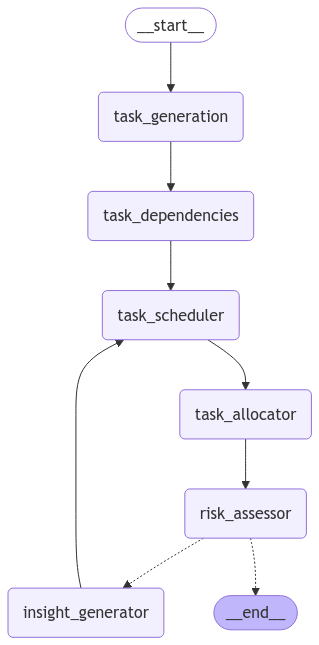

In [8]:
display(
    Image(
        graph_plan.get_graph(xray=1).draw_mermaid_png()
    )
)

### Usage
Project Manager Agent requires a project description (str) and a team (Team) iput next to other initialization parameters. The team is defined as a csv file, composed of 2 columns : Name, Profile Description

In [9]:
def get_project_description(file_path:str):
    """Read the project description from the txt file"""
    with open(file_path, 'r') as file:
        content = file.read()

    return content

def get_team(file_path:str):
    """Read the team members name and description from csv file"""
    team_df = pd.read_csv(file_path)
    team_members = [
        TeamMember(name=row['Name'],
                   profile=row['Profile Description'])
                   for _, row in team_df.iterrows()
    ]
    team = Team(team_members=team_members)
    return team

project_description = get_project_description('project_des.txt')
team = get_team('team_members.csv')

print(project_description)
print(team)

Project: AI-Powered Customer Support Chatbot Development

Project Overview:
Our business aims to develop and deploy an advanced AI-powered chatbot application to provide 24/7 customer support and product recommendations. This chatbot will serve as a virtual assistant to enhance customer experience and reduce support team workload.

Key Requirements:
1. Natural Language Processing capabilities to understand customer queries
2. Integration with existing product database and customer support knowledge base
3. Real-time product recommendations based on customer preferences
4. Multi-platform support (website, mobile app, messaging platforms)
5. Analytics dashboard for monitoring chatbot performance
6. Secure handling of customer data and conversations

Technical Specifications:
- Backend: Python-based architecture with modern AI/ML frameworks
- Frontend: Responsive web interface and mobile-friendly design
- Database: Scalable solution for storing conversation history and analytics
- API Int

In [10]:
state_input = {
    "project_description": project_description,
    "team":team,
    "insights":"",
    "iteration_number":0,
    "max_iteration":3,
    "schedule_iteration":[],
    "task_allocations_iteration":[],
    "project_risk_score_iterations":[],
    "risks_iteration": [],

}

In [13]:
config = {"configurable": {"thread_id":"1"}}
for event in graph_plan.stream(state_input,config,stream_mode=["updates"]):
    "print the different nodes as the agent progresses"
    print(f"Current node: {next(iter(event[1]))}")

Current node: task_generation
Error in dependency mapping: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n\t"tool_call": {\n\t\t"id": "pending",\n\t\t"type": "function",\n\t\t"function": {\n\t\t\t"name": "DependencyList"\n\t\t},\n\t\t"parameters": {\n\t\t\t"dependencies": [\n\t\t\t\t{\n\t\t\t\t\t"task": {\n\t\t\t\t\t\t"description": "Define the scope and objectives of the AI-powered chatbot development project.",\n\t\t\t\t\t\t"estimated_day": 2,\n\t\t\t\t\t\t"id": "19c585a1-01c7-45fb-84c9-359d70db00d8",\n\t\t\t\t\t\t"task_name": "Project Scope Definition"\n\t\t\t\t\t},\n\t\t\t\t\t"dependent_task": [\n\t\t\t\t\t\t{\n\t\t\t\t\t\t\t"description": "Conduct a thorough analysis of existing customer support channels and identify pain points.",\n\t\t\t\t\t\t\t"estimated_day": 3,\n\t\t\t\t\t\t\t"id": "4cb829e

KeyboardInterrupt: 

#### ^^^ The errors due to incompatible output provided by llm

In [13]:
final_state = graph_plan.get_state(config).values
print(final_state['iteration_number'])
print(final_state['project_risk_score_iterations'])


3
[0, 0, 0]


In [14]:
number_of_iter = final_state['iteration_number']

for i in range(number_of_iter):
    task_schedules = final_state['schedule_iteration'][i].schedule

    t = []
    for task_schedule in task_schedules:
        t.append([
            task_schedule.task.task_name,
            task_schedule.start_day,
            task_schedule.end_day
        ])

    df_schedule = pd.DataFrame(t,columns=['task_name','start','end'])

    task_allocations = final_state['task_allocations_iteration'][i].task_allocations

    t =[]

    for task_allocation in task_allocations:
        t.append([
            TaskAllocation.task.task_name,
            task_allocation.team_member.name
        ])

    df_allocation = pd.DataFrame(t,columns=['task_name','team_member'])

    df = df_allocation.merge(df_schedule,on = 'task_name')

    import plotly.express as px

    from datetime import datetime, timedelta

    current_date = datetime.today()

    df['start'] = df['start'].apply(lambda x:current_date + timedelta(days=x))
    df['end'] = df['end'].apply(lambda x:current_date + timedelta(days=x))
    
    df.rename(columns={'team_members':'Team Member'},inplace=True)
    df.sort_values(by='Team Member',inplace=True)

    fig = px.timeline(df, x_start='start',x_end='end',y='task_name', color = 'Team Member', title=f"Gantt Chart - Iteration:{i+1}")


    fig.update_layout(
        xaxis_title="Timeline",
        yaxis_title="Tasks",
        yaxis=dict(autorange="reversed"),
        title_x=0.5
    )

    fig.show()

AttributeError: task

#### Due to the llm not being good we are not getting the results as we are expecting (which is how we described in the prompt) and due to that the pydantic validation is giving error.

If we use a good llm like openai's o1 model we can get good results.